## Author - Lisa Karaseva


## About the data

#### House Sales in King County, USA

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

Link - https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv

#### Variables
- id - notation for a house
- date - Date house was sold
- price - is prediction target
- bedrooms - Number of Bedrooms/House
- bathrooms - Number of bathrooms/House
- sqft_living - square footage of the home
- sqft_lot - square footage of the lot
- floors - Total floors (levels) in house
- waterfront - House which has a view to a waterfront
- view - Has been viewed
- condition - How good the condition is ( Overall )
- grade - overall grade given to the housing unit, based on King County grading system
- sqft_above - square footage of house apart from basement
- sqft_basement - square footage of the basement
- yr_built - Built Year
- yr_renovated - Year when house was renovated
- zipcode - zip
- lat - Latitude coordinate
- long - Longitude coordinate
- sqft_living15 - Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
- sqft_lot15 - lotSize area in 2015(implies-- some renovations)

## Research Summary

#### Goal
Study effect of different variables on price. Build a prediction model for price.

#### Steps taken
1. Exploratory data analysis
    - Correlations
    - Hypothesis tests
2. Feature Engineering
    - Decoding/OHE
    - Transformations/normalization
3. Modeling
    - Least squares with one set of features (more encoded)
    - Least squares with another set of features (less encoded)
    - PCA to address multicollinearity

#### Results
RMSE and general OLS results were reported for each fit attempt. We found that adding an extra polynomial term for sqft_living helped to improve adjusted R squared. PCA helped to address multicolinearity issues and make residuals normally distributed.

#### Future considerations
Even though PCA addressed multicolinearity issues, the overall performance was not bettter than other models and it only led to less interpretable results. Other ways to adress multicolinearity could be approached besed on dropping 1 degree of freedom for every encoded feature (presumably one of the reasons for multicolinarity at the first place) or penalizing these terms with ridge or lasso. Another way is to use Recursive Feature Elimination or similar techiques based on Akaike Information Criteria. 

One of the issues with the dataset itself is not enough examples of expensive houses. Synthetic minority oversampling technique could be used to perhaps enhance the model performance.

Ensemble learning can be applied to reduce RMSE at the expense of interpretability. 


## Read Data

In [1]:
# package import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
from scipy import stats
from sklearn import preprocessing
from statsmodels.stats.multicomp import pairwise_tukeyhsd
pd.set_option('display.float_format', lambda x: '%.3f' % x) # set format for pandas floating numbers
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# read data
filePath = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv"
data = pd.read_csv(filePath)

# view dimensions and data types
data.info()

# convert date to datetime
data.loc[:,'date'] = pd.to_datetime(data.loc[:,'date'])

# see how the data looks like
data.head()

# check for null values
data.isnull().values.any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


False

## Exploratory Analysis

### Summary Statistics

In [3]:
# provide statistical summary for some numerical variables
data.loc[:,['price', 'sqft_living', 'sqft_lot', 'grade','yr_built','floors','bathrooms','bedrooms']].describe().round(1)

,price,sqft_living,sqft_lot,grade,yr_built,floors,bathrooms,bedrooms
count,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000
mean,540088.100,2079.900,15107.000,7.700,1971.000,1.500,2.100,3.400
std,367127.200,918.400,41420.500,1.200,29.400,0.500,0.800,0.900
min,75000.000,290.000,520.000,1.000,1900.000,1.000,0.000,0.000
25%,321950.000,1427.000,5040.000,7.000,1951.000,1.000,1.800,3.000
50%,450000.000,1910.000,7618.000,7.000,1975.000,1.500,2.200,3.000
75%,645000.000,2550.000,10688.000,8.000,1997.000,2.000,2.500,4.000
max,7700000.000,13540.000,1651359.000,13.000,2015.000,3.500,8.000,33.000


Most houses were build around 1975; sold for $450K; had square footage of living spaces around 1910.
You can also note, that distributions of price and variables such as sqft_lot are skewed to the upper tail.

Now let's look into Price distribution, since this is the outcome we want to be able to predict.

### House price distribution

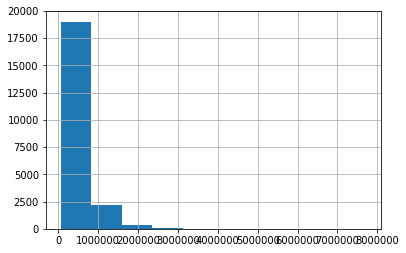

In [4]:
# subset price and perform log transformation
price = data.loc[:,'price']
log_price = np.log(price)
# distribution of price
price.hist();

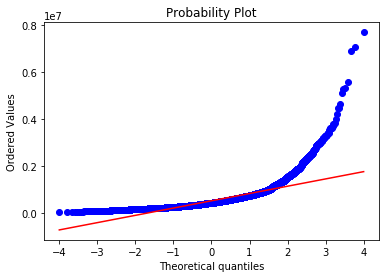

In [5]:
# build qqplot for the price
stats.probplot(price, plot = sns.mpl.pyplot);

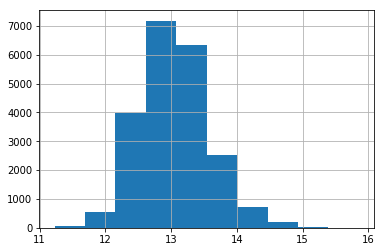

In [6]:
# distribution of log price
log_price.hist();

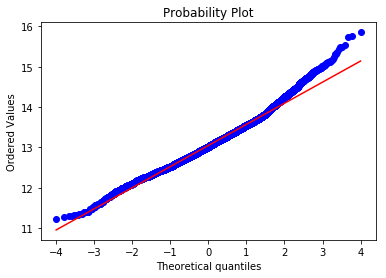

In [7]:
# build qqplot for log price
stats.probplot(log_price, plot = sns.mpl.pyplot);

Log(price) seems to be more compatible with the normal distribution than just the price. Let's run KS test to see what it returns. First, we need to normalize the variables as we'll be comparing them to the normal distribution:

In [8]:
# standardize price and log price for KS normality test
price_scaled = preprocessing.scale(price)
log_price_scaled = preprocessing.scale(log_price)

In [9]:
# Kolmogorov Smirnov test function with nice outputs
def ks_test(dat, dist = 'norm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

In [10]:
# test scaled price for compatability with the normal distribution
ks_test(price_scaled, dist = 'norm')

KS-statistic = 0.1457271152901709
P-value = 0.0


In [11]:
# test scaled price for compatability with the normal distribution
ks_test(log_price_scaled, dist = 'norm')

KS-statistic = 0.025988070503970062
P-value = 4.1903563850987136e-13


As expected, the p-value for the price KS test is low, so we reject the null. KS test for log(price) also returns a low p-value, so we again reject the null, however, log price appears to be more normal.

### House price vs other variables

C:\Users\beeli\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


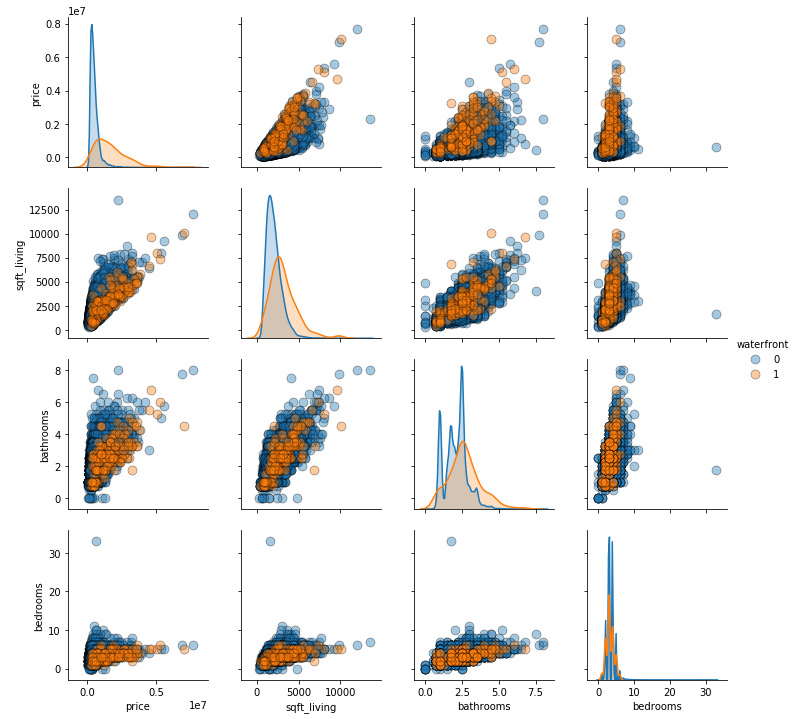

In [12]:
# build a scatter matrix
h = sns.pairplot(data
                ,vars = ['price', 'sqft_living', 'bathrooms','bedrooms']
                ,hue = 'waterfront'
                ,plot_kws = {'alpha': 0.4, 's': 80, 'edgecolor': 'k'})

We can see that prices for houses at the waterfront seem to be higher. The same appears to be true for houses with more views, better conditions or if they were renovated. We can test that later as well.

Is the price different by locations?

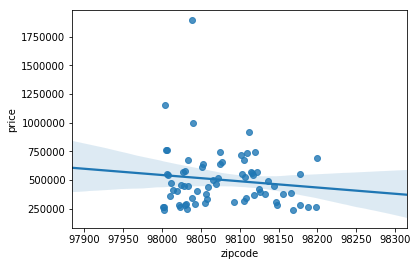

In [13]:
# aggregate median price by zip codes and plot
data['count'] = 1
zips = data.loc[:,['zipcode','price','count']].groupby(by = 'zipcode').agg({'price':'median','count':'sum'}).sort_values(by = 'price', ascending = False)
zips = zips.reset_index()
sns.regplot(x = 'zipcode', y = 'price', data = zips)

Median prices grouped by zip codes also not normally distributed. Would location variable be a latent variable or not? Can we use clustering or other types of grouping to encode these location variables and use for prediction or should location not be used to predict price?

## Feature Engineering

In [14]:
# create log of the price
data.loc[:,'log_price'] = np.log(data.loc[:, 'price'])

In [15]:
# decode yr_built variable
data['yr_built_group'] = pd.qcut(x = data['yr_built']
                                 , q = [0, .25, .5, .75, 1.]
                                 , labels = ['1900_to_1951','1951_to_1975','1975_to_1997','1997_to_2015'])
# OHE yr_built
dummies = pd.get_dummies(data.loc[:, ['yr_built_group']])
data[list(dummies.columns)] = dummies
# OHE_views
dummies = pd.get_dummies(pd.Categorical(data.loc[:, 'view']), prefix = 'view')
data[list(dummies.columns)] = dummies
# OHE_zipcodes
#dummies = pd.get_dummies(pd.Categorical(data.loc[:, 'zipcode']), prefix = 'zip')
#data[list(dummies.columns)] = dummies

In [16]:
# OHE yr_renovated
data['yr_renovated_flag'] = np.where(data['yr_renovated'] == 0, 0, 1)

In [17]:
# create polynomila terms
data['sqft_living_sqr'] = data['sqft_living'] ** 2

### More exploration...

Now as we have less groups for years, we can add this into the equation. We've seen that the price in general increases with the square footage going up. But what about a year of contstruction? Let's also group square footage into larger groups.

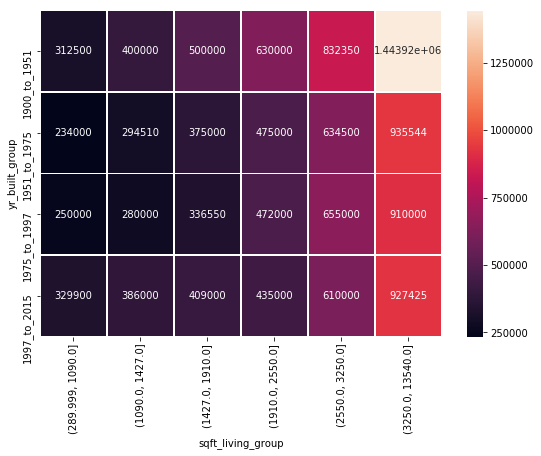

In [19]:
# group square footage of living by quantiles for plotting
data['sqft_living_group'] = pd.qcut(x = data['sqft_living']
                                 , q = [0, .1, .25, .5, .75, .9, 1.])
# pivot median price by yr_built_group and sqft_living_group
data_pivot = pd.pivot_table(data, index='yr_built_group'
                            , columns='sqft_living_group'
                            , values='price'
                            , aggfunc=np.median)
# build a heatmap
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_pivot, annot=True, fmt='g', linewidths=0.6, ax=ax)

The heatmap above confirms the same trend we've seen on a pairplot. But now with added dimension for years when the house was built, it is interesting to see that someone was paying a lot of money for some "ancient" properties.

### Hypothesis Testing

Now let's actually see whether the price is significantly different between different categories. We'll use log(price) as it appears to be more normal

In [20]:
# function to plot histograms with confidence intervals
def plot_hist(x, p=5):
    # Plot the distribution and mark the mean
    plt.hist(x, alpha=.5)
    plt.axvline(x.mean())
    # 95% confidence interval    
    plt.axvline(np.percentile(x, p/2.), color = 'red', linewidth = 3)
    plt.axvline(np.percentile(x, 100-p/2.), color = 'red', linewidth = 3)

In [21]:
# calculate bootstrapped mean difference
def bootstrap_mean_diff(var):
    diffs = []
    for i in range(1000):
        sample = data.sample(frac=1.0, replace=True)
        series_a_mean = sample[sample[var] == 1].log_price.mean()
        series_b_mean = sample[sample[var] == 0].log_price.mean()
        diffs.append(series_a_mean - series_b_mean)
    diffs = pd.Series(diffs)
    return diffs

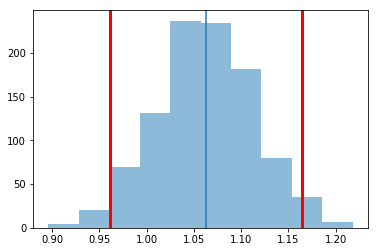

In [22]:
# test the difference in price between places at the waterfront and not
waterfront_mean_diff = bootstrap_mean_diff('waterfront')
plot_hist(waterfront_mean_diff)

Based on the bootstrap mean difference test, we can reject the null hypothesis as there is a difference between price for houses at the waterfront and not

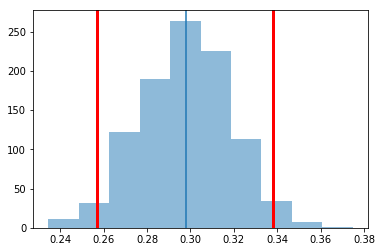

In [23]:
# test the difference in price between places that were/were not renovated
renovated_mean_diff = bootstrap_mean_diff('yr_renovated_flag')
plot_hist(renovated_mean_diff)

Renovated houses also seem to be significantly more expensive than the once that are not. 
Let's also test for difference in variables such as views and condition.

In [24]:
# test for the price difference contingent on number of views in the house
Tukey_HSD = pairwise_tukeyhsd(data['log_price'], data['view'])
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.4703   0.3959 0.5448  True 
  0      2     0.4471   0.4027 0.4915  True 
  0      3     0.6428   0.5825 0.7032  True 
  0      4     1.029    0.9531 1.1049  True 
  1      2    -0.0232  -0.1088 0.0624 False 
  1      3     0.1725   0.0777 0.2674  True 
  1      4     0.5586   0.4532 0.6641  True 
  2      3     0.1957   0.1221 0.2694  True 
  2      4     0.5818   0.495  0.6687  True 
  3      4     0.3861   0.2901 0.4821  True 
--------------------------------------------


In [25]:
# test for the price difference contingent on the condition
Tukey_HSD = pairwise_tukeyhsd(data['log_price'], data['condition'])
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.0469  -0.2354 0.3293 False 
  1      3     0.5652   0.3044 0.826   True 
  1      4     0.5208   0.2596 0.782   True 
  1      5     0.667    0.4042 0.9298  True 
  2      3     0.5183   0.4088 0.6278  True 
  2      4     0.4739   0.3634 0.5843  True 
  2      5     0.6201   0.5059 0.7343  True 
  3      4    -0.0444  -0.0669 -0.022  True 
  3      5     0.1018   0.0652 0.1385  True 
  4      5     0.1463   0.1068 0.1857  True 
--------------------------------------------


For both view and condition the difference in the log price is significant in almost all cases

## Modeling - Predict Price

Now we've reviewed relationships of price and log price with other variables. But the last step, before we go further, would be to check for correlation betweeen predictors

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built_group_1951_to_1975,yr_built_group_1975_to_1997,yr_built_group_1997_to_2015,view_0,view_1,view_2,view_3,view_4,yr_renovated_flag,sqft_living_sqr
id,1.000,-0.017,0.001,0.005,-0.012,-0.132,0.019,-0.003,0.012,-0.024,...,-0.042,-0.005,0.047,-0.011,0.002,0.015,-0.013,0.017,-0.017,-0.020
price,-0.017,1.000,0.308,0.525,0.702,0.090,0.257,0.266,0.397,0.036,...,-0.114,-0.011,0.121,-0.359,0.093,0.148,0.183,0.308,0.126,0.727
bedrooms,0.001,0.308,1.000,0.516,0.577,0.032,0.175,-0.007,0.080,0.028,...,0.073,0.049,0.081,-0.080,0.022,0.045,0.050,0.035,0.019,0.473
bathrooms,0.005,0.525,0.516,1.000,0.755,0.088,0.501,0.064,0.188,-0.125,...,-0.220,0.181,0.414,-0.177,0.038,0.087,0.112,0.108,0.050,0.673
sqft_living,-0.012,0.702,0.577,0.755,1.000,0.173,0.354,0.104,0.285,-0.059,...,-0.121,0.128,0.248,-0.271,0.067,0.135,0.159,0.169,0.055,0.936
sqft_lot,-0.132,0.090,0.032,0.088,0.173,1.000,-0.005,0.022,0.075,-0.009,...,-0.013,0.106,-0.028,-0.068,-0.008,0.037,0.074,0.019,0.008,0.178
floors,0.019,0.257,0.175,0.501,0.354,-0.005,1.000,0.024,0.029,-0.264,...,-0.426,0.068,0.579,-0.018,-0.023,0.010,0.020,0.025,0.006,0.299
waterfront,-0.003,0.266,-0.007,0.064,0.104,0.022,0.024,1.000,0.402,0.017,...,0.005,-0.008,-0.020,-0.264,-0.007,0.002,0.053,0.588,0.093,0.120
view,0.012,0.397,0.080,0.188,0.285,0.075,0.029,0.402,1.000,0.046,...,0.012,-0.012,-0.043,-0.926,0.125,0.498,0.561,0.601,0.104,0.290
condition,-0.024,0.036,0.028,-0.125,-0.059,-0.009,-0.264,0.017,0.046,1.000,...,0.208,-0.064,-0.348,-0.047,0.020,0.027,0.016,0.030,-0.060,-0.058


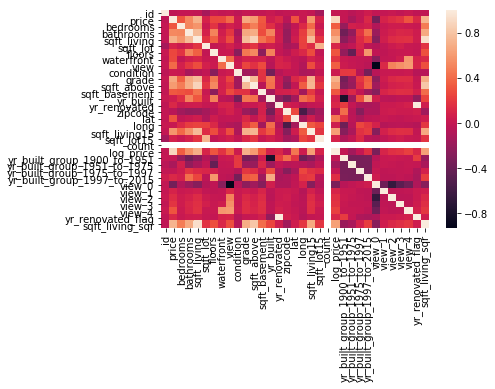

In [26]:
# build a correlation matrix + plot
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
corr

You can see, that there are not a lot of strong negative correlations, but there are some strong positive correlations like sqft_living vs price, or grade vs price. 

### Approach 1 - OLS using encoded features for yr_built and view + polynomial term for sqft_living

Based on the explorations above and previous findings  let's select some of the variables that had strong relationships with price and apply least squares to build a regression model  

In [27]:
# function to fit lm model using ols method
def lm_fit(response, selected):
    X = data.loc[: , selected].values
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    ## Normalize numeric variables
    minmaxscaler = MinMaxScaler().fit(X)
    X_scaled = minmaxscaler.transform(X)

    # put x and y back into a data frame
    data_lm = pd.DataFrame(X_scaled, columns = selected)
    data_lm[response] = data[response]

    # fit linear model for all selected features
    ols_model = sm.ols(formula = formula, data = data_lm)
    results = ols_model.fit()

    # add predicted values back to a data frame
    x_input = data_lm.drop(columns = 'log_price')
    y_pred = results.predict(x_input)
    data_lm['predicted_log_price'] = y_pred
    
    # reshpape y output
    n_points = data_lm.shape[0]
    y_output = data_lm[response].values.reshape(n_points, 1)

    # calculate different measures of explained/unexplained variance
    print('\nSSE, SST, SSR, and RMSE:')
    mean_y = np.mean(y_output)
    sst = np.sum((y_output - mean_y)**2)
    sse = sst - results.ssr
    print('SSE: {}'.format(sse))
    print('SST: {}'.format(sst))
    print('SSR: {}'.format(results.ssr))
    print('RMSE: {}'.format(np.sqrt(results.mse_model)))

    # Get most of the linear regression statistics we are interested in:
    print(results.summary())

    # Plot a histogram of the residuals
    sns.distplot(results.resid, hist=True)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Residual Histogram')
    
    return data_lm, results


SSE, SST, SSR, and RMSE:
SSE: 4308.4471705079395
SST: 5995.094942910211
SSR: 1686.6477724022716
RMSE: 15.919738341235643
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     3245.
Date:                Mon, 29 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:51:51   Log-Likelihood:                -3105.0
No. Observations:               21613   AIC:                             6246.
Df Residuals:                   21595   BIC:                             6390.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025     

C:\Users\beeli\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


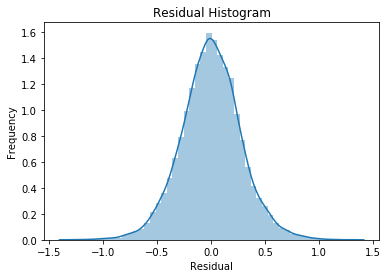

In [28]:
# subset variables and fit
response = 'log_price'
selected = ['sqft_living', 'sqft_living_sqr', 'waterfront', 'condition', 'yr_renovated_flag', 'lat', 'long', 'zipcode', 'floors', 'bathrooms', 'yr_built_group_1900_to_1951','yr_built_group_1951_to_1975','yr_built_group_1975_to_1997','yr_built_group_1997_to_2015', 'view_0', 'view_1', 'view_2', 'view_3', 'view_4']
data_lm, results = lm_fit(response, selected)

This trial is a signifficant improvement over other previous attempts not shown in the notebook. 

What did we change:
- changed price for log_price
- added polynomial term for sqft_living
- added extra features for view

Diagnostics:
1. Adj. R squared improved from 0.643 to 0.718
2. Residuals became more normally distributed
3. But there is an indication of potential multicollinearity problems

### Approach 2 - OLS not using encoded features + polynomial term for sqft_living


SSE, SST, SSR, and RMSE:
SSE: 4284.157578361575
SST: 5995.094942910211
SSR: 1710.937364548636
RMSE: 18.894791121632736
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     4507.
Date:                Mon, 29 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:51:52   Log-Likelihood:                -3259.5
No. Observations:               21613   AIC:                             6545.
Df Residuals:                   21600   BIC:                             6649.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----

C:\Users\beeli\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


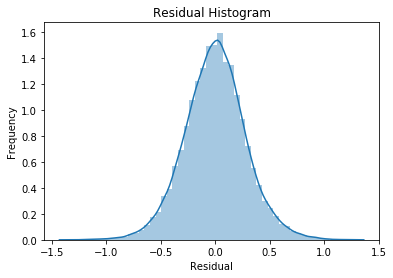

In [29]:
selected = ['sqft_living', 'sqft_living_sqr', 'waterfront', 'condition', 'yr_renovated_flag', 'yr_built', 'view', 'lat', 'long', 'zipcode', 'floors', 'bathrooms']
data_lm, results = lm_fit(response, selected)

This trial as well seems to be better than an attempt made in Milestone 3. 

What did we change:
- changed price for log_price
- added polynomial term for sqft_living
- used features as they are without decoding

Diagnostics:
1. Adj. R squared improved from 0.643 to 0.714 (a little worse than the previous attempt)
2. Residuals are still normally distributed
3. Results summary no longer gives us an indication of multicollinearity

### Approach 3 - PCR to address multicolinearity

Text(0, 0.5, 'Variance explained')

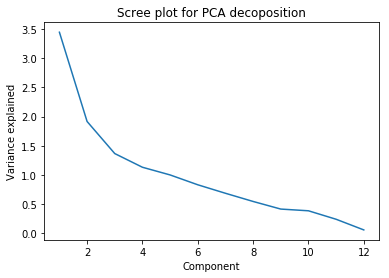

In [30]:
# Select features for PCA
selected = ['sqft_living', 'sqft_living_sqr', 'waterfront', 'condition', 'yr_renovated_flag', 'yr_built', 'view', 'lat', 'long', 'zipcode', 'floors', 'bathrooms']
# Subset X
X = data.loc[:, selected].values

# Scale the points
X = StandardScaler().fit_transform(X)

# find principle components
pca = PCA()
pca_result = pca.fit_transform(X)
pca_df = pd.DataFrame(data = pca_result, columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12'])

# display explained variance by principle components
plt.plot([i + 1 for i in range(12)], pca.explained_variance_)
plt.title('Plot for PCA decoposition')
plt.xlabel('Component')
plt.ylabel('Variance explained')

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     4507.
Date:                Mon, 29 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:51:53   Log-Likelihood:                -3259.5
No. Observations:               21613   AIC:                             6545.
Df Residuals:                   21600   BIC:                             6649.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0478      0.002   6815.617      0.0

C:\Users\beeli\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Residual Histogram')

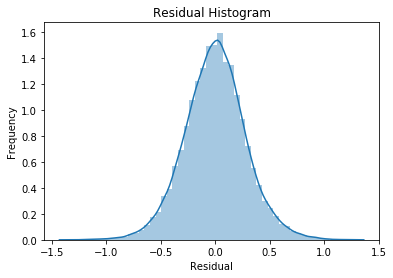

In [31]:
# add response to the pca dataframe
pca_df['log_price'] = data['log_price']

# fit in ols model
pcr_model = sm.ols(formula = 'log_price ~ pc1 + pc2 + pc3 + pc4 + pc5 + pc6 + pc7 + pc8 + pc9 + pc10 + pc11 + pc12', data=pca_df)

# reshape response variable
results = pcr_model.fit()
n_points = pca_df.shape[0]
y_output = pca_df['log_price'].values.reshape(n_points, 1)

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

This trial as well seems to be better than an attempt made in Milestone 3. 

What did we change:
- used the same variables we had in the first attempt
- but applied PCA to address multicollinearity issue

Diagnostics:
1. Adj. R squared improved from 0.643 to 0.714 (a little worse than initial attempt and similar to the previous one)
2. Residuals are still normally distributed
3. Results summary no longer gives us an indication of multicollinearity